## Data exploration

In [ ]:
import numpy as np
import dogs_vs_cats as dvc
import matplotlib.pyplot as plt
%matplotlib inline

all_files = dvc.image_files()

Using Theano backend.


data file train.zip has already been downloaded
Data has already been extracted


In [ ]:
n_images_train=5000
n_images_val=500
n_images_test=500
input_image_shape = (3,50,50) 
_, _,train_and_val_files, \
test_features, test_labels, test_files = dvc.training_test_datasets(all_files,
                                                                    n_images_train+n_images_val,n_images_test,
                                                                    input_image_shape)

train_features,train_labels, train_files,\
val_features,val_labels,val_files =  dvc.training_test_datasets(train_and_val_files,
                                                               n_images_train,n_images_val,
                                                               input_image_shape)




Loading train set
loading image (1/5500)
loading image (101/5500)
loading image (201/5500)
loading image (301/5500)
loading image (401/5500)
loading image (501/5500)
loading image (601/5500)
loading image (701/5500)
loading image (801/5500)
loading image (901/5500)
loading image (1001/5500)
loading image (1101/5500)
loading image (1201/5500)
loading image (1301/5500)
loading image (1401/5500)
loading image (1501/5500)
loading image (1601/5500)
loading image (1701/5500)
loading image (1801/5500)
loading image (1901/5500)
loading image (2001/5500)
loading image (2101/5500)
loading image (2201/5500)
loading image (2301/5500)
loading image (2401/5500)
loading image (2501/5500)
loading image (2601/5500)
loading image (2701/5500)
loading image (2801/5500)
loading image (2901/5500)
loading image (3001/5500)
loading image (3101/5500)
loading image (3201/5500)
loading image (3301/5500)
loading image (3401/5500)
loading image (3501/5500)
loading image (3601/5500)
loading image (3701/5500)


In [ ]:
train_features.shape, train_labels.shape,train_files[:10],train_labels[:10]

In [ ]:

index_example = 32
fig,ax = plt.subplots(1,2,figsize=(14,8))
ax[0].imshow(train_features[index_example,].transpose((1,2,0)))
ax[1].set_title(train_files[index_example])
_ = ax[1].hist(train_features[index_example,].ravel(),bins=40)


## Preprocessing

In [ ]:
media = np.mean(train_features,axis=(0,2,3))
media = media[:,np.newaxis,np.newaxis]
train_features-=media
val_features-=media
test_features-=media

In [ ]:
_ = plt.hist(train_features[:,0,:,:].ravel())

## FC network

`keras` notation:
* *epoch*:  Each epoch is a full loop over **all** the training data.
* `nb_epoch`: Number of epochs to train the model. 
* `batch_size`: Number of samples to use in each *stochastic* gradient update.

For example, 80 epochs consist on 80 loops over all the training examples. If there are 1000 examples and batch size is set to 32 there will be 1000/32 * 80 gradient updates. Each gradient is estimated using 32 samples.

In [ ]:
input_shape_flat = np.prod(input_image_shape)
train_features_flat = train_features.reshape((train_features.shape[0],input_shape_flat))
val_features_flat = val_features.reshape((val_features.shape[0],input_shape_flat))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation

fc_model = Sequential([
    Dense(1024, input_dim=input_shape_flat),
    Activation('sigmoid'),
    Dense(512),
    Activation('sigmoid'),
    Dense(256),
    Activation('sigmoid'),
    Dense(1),
    Activation('sigmoid')
])

fc_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

nb_epoch=20
hist=fc_model.fit(train_features_flat,
                  train_labels, 
                  nb_epoch=nb_epoch,validation_data=(val_features_flat,
                                               val_labels),
                  batch_size=32,verbose=2)

In [9]:
hist.history

{'acc': [0.55659999999999998,
  0.61240000000000006,
  0.64659999999999995,
  0.70720000000000005,
  0.74339999999999995,
  0.79039999999999999,
  0.83540000000000003,
  0.878,
  0.90759999999999996,
  0.92859999999999998,
  0.93620000000000003,
  0.95040000000000002,
  0.9506,
  0.95899999999999996,
  0.96860000000000002,
  0.96999999999999997,
  0.96379999999999999,
  0.97499999999999998,
  0.96960000000000002,
  0.98080000000000001],
 'loss': [0.68927120819091792,
  0.65378112545013423,
  0.62081588821411138,
  0.56541593694686887,
  0.50919677181243894,
  0.44311688575744629,
  0.37020641789436343,
  0.28494734385013581,
  0.23119858064651488,
  0.18783517496585847,
  0.15965124170780182,
  0.12030524183735251,
  0.13290094228833912,
  0.10319925007224083,
  0.08155734494924545,
  0.073155424875020983,
  0.092966306853294378,
  0.071615217930823566,
  0.076653845405578611,
  0.050477597018331287],
 'val_acc': [0.55000000000000004,
  0.5419999995231628,
  0.60600000095367434,
  0.60

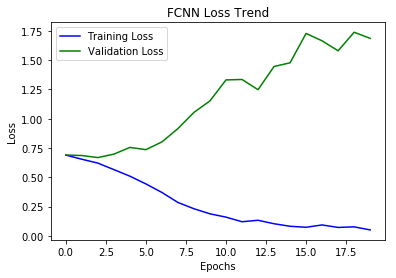

In [10]:
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('FCNN Loss Trend')
plt.plot(hist.history["loss"], 'blue', label='Training Loss')
plt.plot(hist.history["val_loss"], 'green', label='Validation Loss')
#plt.xticks(range(0,nb_epoch,2))
plt.legend()

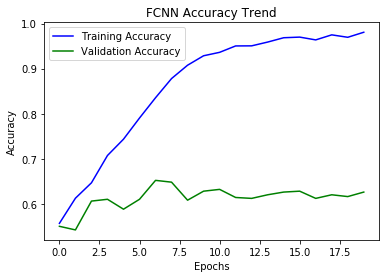

In [11]:
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('FCNN Accuracy Trend')
plt.plot(hist.history["acc"], 'blue', label='Training Accuracy')
plt.plot(hist.history["val_acc"], 'green', label='Validation Accuracy')
plt.legend()

## CNN

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping

def catdog(input_image_shape):
    model = Sequential()
    model.add(Convolution2D(32, 3, 3,input_shape=input_image_shape))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    model.add(Convolution2D(32, 3, 3))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(64, 3, 3))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(128, 3, 3))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    model.add(Convolution2D(128, 3, 3))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    
    model.add(Activation('sigmoid'))
    optimizer = Adam()
    objective = 'binary_crossentropy'
    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

cnn_model = catdog(input_image_shape)
nb_epoch=80
print("Model compiled, start training")
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, 
                                        verbose=0, mode='auto')
history = cnn_model.fit(train_features, train_labels,validation_data=(val_features,val_labels),
                        batch_size=32, nb_epoch=nb_epoch,verbose=2,callbacks=[early_stopping_callback])


Model compiled, start training
Train on 5000 samples, validate on 500 samples
Epoch 1/80
98s - loss: 0.7625 - acc: 0.5706 - val_loss: 0.8129 - val_acc: 0.5040
Epoch 2/80
95s - loss: 0.6440 - acc: 0.6310 - val_loss: 1.0016 - val_acc: 0.5040
Epoch 3/80
62s - loss: 0.6008 - acc: 0.6776 - val_loss: 0.6074 - val_acc: 0.6360
Epoch 4/80
62s - loss: 0.5630 - acc: 0.7136 - val_loss: 0.9268 - val_acc: 0.5620
Epoch 5/80
63s - loss: 0.5132 - acc: 0.7364 - val_loss: 0.5539 - val_acc: 0.7180
Epoch 6/80
61s - loss: 0.4828 - acc: 0.7714 - val_loss: 0.7234 - val_acc: 0.6080
Epoch 7/80
92s - loss: 0.4466 - acc: 0.7984 - val_loss: 0.6189 - val_acc: 0.6820
Epoch 8/80
113s - loss: 0.4294 - acc: 0.7990 - val_loss: 0.4966 - val_acc: 0.7660
Epoch 9/80
112s - loss: 0.4016 - acc: 0.8204 - val_loss: 0.5333 - val_acc: 0.7720
Epoch 10/80
112s - loss: 0.3592 - acc: 0.8414 - val_loss: 0.5861 - val_acc: 0.7080
Epoch 11/80
107s - loss: 0.3413 - acc: 0.8468 - val_loss: 0.5980 - val_acc: 0.6960
Epoch 12/80
105s - loss: 

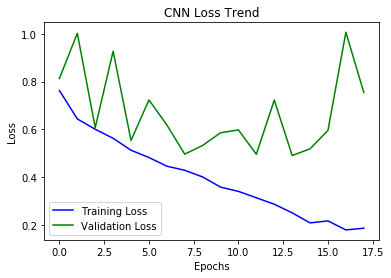

In [14]:
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Loss Trend')
plt.plot(history.history["loss"], 'blue', label='Training Loss')
plt.plot(history.history["val_loss"], 'green', label='Validation Loss')
#plt.xticks(range(0,nb_epoch,2))
plt.legend()

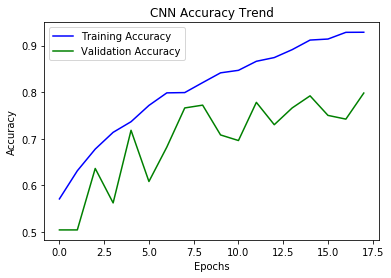

In [15]:
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Accuracy Trend')
plt.plot(history.history["acc"], 'blue', label='Training Accuracy')
plt.plot(history.history["val_acc"], 'green', label='Validation Accuracy')
plt.legend()

In [16]:
# evaluate the model
results = cnn_model.evaluate(test_features,test_labels)
print(" ".join(["%s: %.4f"%(metric_name,valor) for metric_name,valor in zip(cnn_model.metrics_names,results)]))

500/500 [==============================] - 3s     
loss: 0.6211 acc: 0.8100


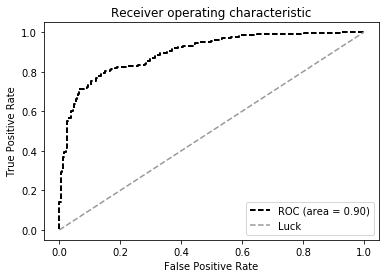

In [17]:
preds = cnn_model.predict(test_features)
dvc.plotROC(test_labels,preds)